In [1]:

import os, sys
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import time
from dateutil.relativedelta import *
import matplotlib.pyplot as plt

import warnings; warnings.simplefilter('ignore')
pd.set_option('display.max_colwidth', 5000)
pd.set_option('display.max_rows', 100)

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import add_changepoints_to_plot

import joblib

Importing plotly failed. Interactive plots will not work.


In [2]:
ticker = '^FCHI'
pred_threshold = 1

file = 'D:/Users/masoodw/ML_FINANCE/python/WEB_PROJECT/ASSETBOX/ASSETSIGHTAPP/FORECASTUPDATE/data/index_price.csv'
df_quotes = pd.read_csv(file, sep = ';')
df_quotes.index = pd.to_datetime(df_quotes.Datetime)
df_data = df_quotes[df_quotes['Symbol']==ticker]
#df_data = df_data.drop(['Datetime', 'Symbol'],axis=1)
df_data['daily_returns'] = df_data.Close.pct_change()*100
df_data['daily_returns_1'] = df_data['daily_returns'].shift(-1)

In [10]:
df_data.head()

,Datetime,Open,High,Low,Close,Volume,Symbol,Adj_Close,daily_returns,daily_returns_1
Datetime,,,,,,,,,,
2010-01-04 09:00:00,2010-01-04 09:00:00,3952.209961,4013.969971,3950.610107,4013.969971,113396000.0,^FCHI,4013.969971,NaN,-0.026409
2010-01-05 09:00:00,2010-01-05 09:00:00,4012.429932,4028.340088,3993.330078,4012.909912,129518600.0,^FCHI,4012.909912,-0.026409,0.118617
2010-01-06 09:00:00,2010-01-06 09:00:00,4014.449951,4022.939941,3996.800049,4017.669922,110087000.0,^FCHI,4017.669922,0.118617,0.177469
2010-01-07 09:00:00,2010-01-07 09:00:00,4005.959961,4032.239990,3983.899902,4024.800049,118430400.0,^FCHI,4024.800049,0.177469,0.505363
2010-01-08 09:00:00,2010-01-08 09:00:00,4042.639893,4051.409912,4013.340088,4045.139893,131783200.0,^FCHI,4045.139893,0.505363,-0.050673


In [11]:
df_price = pd.DataFrame()
df_price['ds'] = pd.to_datetime(df_data.Datetime)
df_price['y'] = df_data['Close']
df_price

,ds,y
Datetime,,
2010-01-04 09:00:00,2010-01-04 09:00:00,4013.969971
2010-01-05 09:00:00,2010-01-05 09:00:00,4012.909912
2010-01-06 09:00:00,2010-01-06 09:00:00,4017.669922
2010-01-07 09:00:00,2010-01-07 09:00:00,4024.800049
2010-01-08 09:00:00,2010-01-08 09:00:00,4045.139893
...,...,...
2020-08-10 09:00:00,2020-08-10 09:00:00,4909.509766
2020-08-11 09:00:00,2020-08-11 09:00:00,5027.990234
2020-08-12 09:00:00,2020-08-12 09:00:00,5073.310059


In [13]:
#df_forecast[df_forecast['ds'].dt.dayofweek < 5]
df_price = df_price[df_price['ds'].dt.dayofweek <= 5 ]

In [14]:
test_window = 7 ### days
max_rows = df_price.shape[0]

df_train = df_price[0:max_rows-test_window]
df_test = df_price[max_rows-test_window:max_rows]
df_train.shape, df_test.shape

((2708, 2), (7, 2))

In [15]:
df_train.tail(test_window)

,ds,y
Datetime,,
2020-07-28 09:00:00,2020-07-28 09:00:00,4928.939941
2020-07-29 09:00:00,2020-07-29 09:00:00,4958.740234
2020-07-30 09:00:00,2020-07-30 09:00:00,4852.939941
2020-07-31 09:00:00,2020-07-31 09:00:00,4783.689941
2020-08-03 09:00:00,2020-08-03 09:00:00,4875.930176
2020-08-04 09:00:00,2020-08-04 09:00:00,4889.520020
2020-08-05 09:00:00,2020-08-05 09:00:00,4933.339844


In [16]:
df_test.tail(test_window)

,ds,y
Datetime,,
2020-08-06 09:00:00,2020-08-06 09:00:00,4885.129883
2020-08-07 09:00:00,2020-08-07 09:00:00,4889.520020
2020-08-10 09:00:00,2020-08-10 09:00:00,4909.509766
2020-08-11 09:00:00,2020-08-11 09:00:00,5027.990234
2020-08-12 09:00:00,2020-08-12 09:00:00,5073.310059
2020-08-13 09:00:00,2020-08-13 09:00:00,5042.379883
2020-08-14 09:00:00,2020-08-14 09:00:00,4962.930176


In [17]:
df_prophet = Prophet(changepoint_prior_scale=0.15, daily_seasonality=True)
df_prophet.fit(df_train)

In [18]:
fcast_time=test_window
df_forecast = df_prophet.make_future_dataframe(periods= fcast_time, freq='D', include_history=True)
df_forecast

,ds
0,2010-01-04 09:00:00
1,2010-01-05 09:00:00
2,2010-01-06 09:00:00
3,2010-01-07 09:00:00
4,2010-01-08 09:00:00
...,...
2710,2020-08-08 09:00:00
2711,2020-08-09 09:00:00
2712,2020-08-10 09:00:00
2713,2020-08-11 09:00:00


In [19]:
# Forecasting - call the method predict
df_forecast = df_prophet.predict(df_forecast)

In [20]:
df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2010-01-04 09:00:00,3830.921383,3529.223827,4142.754444
1,2010-01-05 09:00:00,3839.559274,3528.093098,4147.696131
2,2010-01-06 09:00:00,3841.083490,3533.738393,4170.746999
3,2010-01-07 09:00:00,3846.304394,3556.059898,4161.250317
4,2010-01-08 09:00:00,3851.567116,3517.190782,4148.693935
...,...,...,...,...
2710,2020-08-08 09:00:00,5187.194884,4894.941837,5480.135523
2711,2020-08-09 09:00:00,5183.494615,4909.335452,5517.723464
2712,2020-08-10 09:00:00,5169.150600,4853.051039,5485.648179
2713,2020-08-11 09:00:00,5170.350083,4870.856207,5463.534482


In [22]:
df_test-df_forecast.yhat

UFuncTypeError: ufunc 'subtract' cannot use operands with types dtype('<M8[ns]') and dtype('float64')

### Cross Validation

In [15]:
cutoffs = pd.to_datetime(['2020-07-23', '2020-08-01', '2018-08-15'])

In [45]:
df_cv = cross_validation(df_prophet, initial='2600', period='100 days', horizon = '14 days')

INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-02-13 09:00:00 and 2020-07-10 09:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-02-15 09:00:00,3374.089838,3331.744902,3415.426173,3609.219971,2010-02-13 09:00:00
1,2010-02-16 09:00:00,3119.319277,3055.635065,3180.267775,3669.040039,2010-02-13 09:00:00
2,2010-02-17 09:00:00,2685.531769,2603.461766,2773.620660,3725.209961,2010-02-13 09:00:00
3,2010-02-18 09:00:00,2061.445172,1954.243803,2181.866261,3747.830078,2010-02-13 09:00:00
4,2010-02-19 09:00:00,1226.519393,1084.563475,1379.578854,3769.540039,2010-02-13 09:00:00


In [47]:
df_cv.tail(100)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
279,2017-10-23 09:00:00,5396.091882,5231.082922,5548.899827,5386.810059,2017-10-14 09:00:00
280,2017-10-24 09:00:00,5402.878236,5242.704377,5551.680335,5394.799805,2017-10-14 09:00:00
281,2017-10-25 09:00:00,5410.112915,5253.952042,5564.928347,5374.890137,2017-10-14 09:00:00
282,2017-10-26 09:00:00,5416.690534,5274.875336,5565.997023,5455.399902,2017-10-14 09:00:00
283,2017-10-27 09:00:00,5420.082915,5262.420447,5558.424318,5494.129883,2017-10-14 09:00:00
284,2018-01-23 09:00:00,5591.592085,5429.398755,5748.492702,5535.259766,2018-01-22 09:00:00
285,2018-01-24 09:00:00,5595.314616,5446.320952,5749.283675,5495.160156,2018-01-22 09:00:00
286,2018-01-25 09:00:00,5599.583786,5443.625929,5760.838841,5481.209961,2018-01-22 09:00:00
287,2018-01-26 09:00:00,5599.907639,5434.553354,5772.764660,5529.149902,2018-01-22 09:00:00
288,2018-01-29 09:00:00,5601.344796,5448.629029,5755.213580,5521.589844,2018-01-22 09:00:00


In [49]:
df_p = performance_metrics(df_cv)

In [50]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,2 days,1.276392e+05,357.266340,217.936238,0.049594,0.028188,0.501502
1,3 days,8.997528e+04,299.958802,212.999190,0.048475,0.032823,0.467467
2,4 days,9.968755e+04,315.733358,238.491891,0.054383,0.043659,0.382536
3,5 days,1.872541e+05,432.728694,281.955823,0.066128,0.046736,0.357143
4,6 days,2.988025e+05,546.628334,301.807431,0.072670,0.039385,0.438224
5,7 days,1.953593e+05,441.994628,283.338379,0.067745,0.037952,0.464286
6,8 days,2.078551e+05,455.911248,308.907710,0.073503,0.067503,0.393822
7,9 days,1.470870e+06,1212.794315,497.990550,0.125086,0.060880,0.323243
8,10 days,2.850933e+06,1688.470462,632.571448,0.160827,0.060880,0.345114
9,11 days,4.790028e+06,2188.613272,765.256097,0.197554,0.046565,0.339768


### Ploting

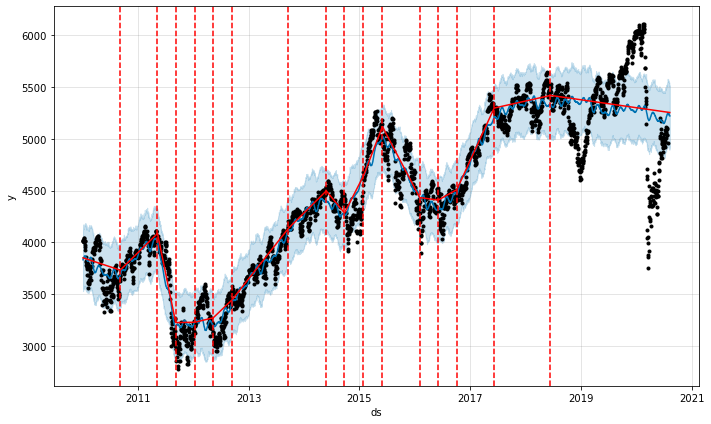

In [59]:
fig = df_prophet.plot(df_forecast)
a = add_changepoints_to_plot(fig.gca(), df_prophet, df_forecast)

In [101]:
### Adding seasonality

In [113]:
df_prophet = Prophet(changepoint_prior_scale=0.01, holidays=None, daily_seasonality=False,
                     weekly_seasonality=False, yearly_seasonality=False, mcmc_samples = 300)

#df_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
#df_prophet.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)

In [ ]:
df_prophet.fit(df_train, n_jobs=1)

In [ ]:
df_cv = cross_validation(df_prophet, initial='2600', period='100 days', horizon = '14 days')

In [ ]:
df_p = performance_metrics(df_cv)

In [107]:
fcast_time=test_window
df_forecast = df_prophet.make_future_dataframe(periods= fcast_time, freq='D', include_history=True)

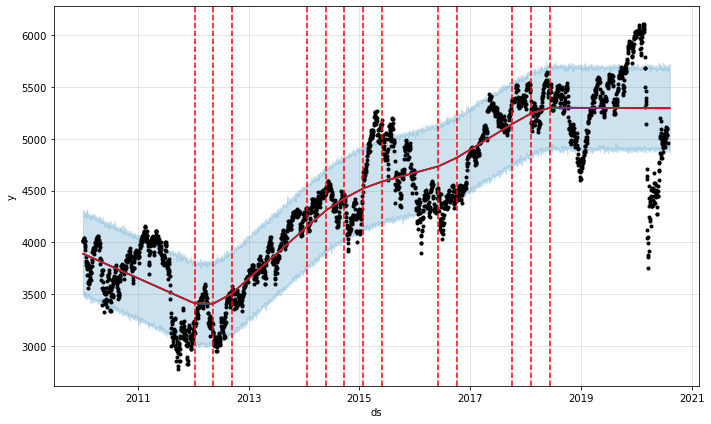

In [108]:
df_forecast = df_prophet.predict(df_forecast)
df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
fig = df_prophet.plot(df_forecast)
a = add_changepoints_to_plot(fig.gca(), df_prophet, df_forecast)


# Hyper-parameter tuning

In [47]:
import itertools


param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode' : ['additive', 'multiplicative'],
    'changepoint_range': [0.85, 0.90, 0.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here


In [48]:
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_price)  # Fit model with given params
    df_cv = cross_validation(m,  initial='2600', period='100 days', horizon = '7 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 09:00:00 and 2020-08-07 09:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 09:00:00 and 2020-08-07 09:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 09:00:00 and 2020-08-07 09:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 09:00:00 and 2020-08-07 09:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 09:00:00 and 2020-08-07

In [50]:
#df_p
#min(rmses)
#len(rmses)
rmses

[381.5108216520367,
 386.19481576730175,
 383.2411337365661,
 381.6720871662505,
 386.0371349927477,
 383.5284684498207,
 382.0606775402078,
 389.6353455640277,
 383.99447682632837,
 385.08728146273995,
 389.88841451352323,
 387.2206062569404,
 384.00062975029925,
 387.441797760887,
 386.21803191656915,
 387.77564003169107,
 388.0247323266241,
 388.0987805556734,
 402.8775680736491,
 408.86097747562627,
 402.95606432696354,
 403.8755747921135,
 405.3764606762797,
 402.46770291370865,
 299.22806693409257,
 286.4830389446865,
 283.44540888503974,
 300.98754018293863,
 286.44418925770276,
 283.0948487221793,
 297.9763796491431,
 287.0263947614579,
 283.8711987935353,
 293.7976138701855,
 270.40582738971034,
 270.85320921093376,
 300.7854204433826,
 289.36238612012045,
 287.71373840637494,
 282.252211240494,
 260.4463741131146,
 217.98414780774175,
 320.9439331388915,
 305.9650972940454,
 307.88941153754735,
 302.51366179323344,
 279.2881459406505,
 244.71151173808207,
 254.3965106553286,


In [49]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01         additive   
2                     0.001                     0.01         additive   
3                     0.001                     0.01   multiplicative   
4                     0.001                     0.01   multiplicative   
5                     0.001                     0.01   multiplicative   
6                     0.001                     0.10         additive   
7                     0.001                     0.10         additive   
8                     0.001                     0.10         additive   
9                     0.001                     0.10   multiplicative   
10                    0.001                     0.10   multiplicative   
11                    0.001                     0.10   multiplicative   
12                    0.001                     1.0

In [51]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


In [266]:
best_params

{'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 0.1,
 'seasonality_mode': 'multiplicative',
 'changepoint_range': 0.95}

In [268]:
f = open("dict.txt","w")
f.write( str(best_params) )
f.close()

In [269]:
with open('dict.txt', 'r') as file:
    best_params = file.read().replace('\n', '')
    best_params = eval(best_params)


In [270]:
best_params

{'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 0.1,
 'seasonality_mode': 'multiplicative',
 'changepoint_range': 0.95}

In [272]:
mdl_prophet = Prophet(**best_params)

In [273]:
mdl_prophet.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
df_cv = cross_validation(mdl_prophet, initial='2600', period='100 days', horizon = '7 days')

In [274]:
fcast_time=9
df_forecast_w_history = mdl_prophet.make_future_dataframe(periods= fcast_time, freq='D', include_history=True)
df_forecast_w_history = df_forecast_w_history[df_forecast_w_history['ds'].dt.dayofweek < 5]

# Forecasting

In [282]:

df_prophet = Prophet(changepoint_prior_scale= 0.5, seasonality_prior_scale= 0.1, 
                     seasonality_mode= 'multiplicative', changepoint_range= 0.95)

In [283]:
df_prophet.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
df_cv = cross_validation(df_prophet, initial='2600', period='100 days', horizon = '7 days')

In [55]:
df_p = performance_metrics(df_cv, rolling_window=0)

In [57]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,29231.361246,170.971814,129.465787,0.029123,0.022892,0.520000
1,2 days,26104.068155,161.567534,128.707590,0.030158,0.024116,0.538462
2,3 days,46843.964408,216.434665,144.646679,0.033760,0.021679,0.535714
3,4 days,51240.982147,226.364710,145.554085,0.033882,0.020953,0.592593
4,5 days,55430.393423,235.436602,163.172860,0.037572,0.022041,0.538462
5,6 days,60355.244069,245.673043,186.145078,0.042431,0.034571,0.428571
6,7 days,78252.600701,279.736663,222.741386,0.052308,0.045079,0.296296


### Forecasting with History

In [284]:
fcast_time=9
df_prophet_forecast = df_prophet.make_future_dataframe(periods= fcast_time, freq='D', include_history=True)
df_forecast_w_history = df_forecast_w_history[df_forecast_w_history['ds'].dt.dayofweek < 5]

In [286]:
df_forecast_w_history = df_prophet.predict(df_forecast_w_history)
df_forecast_w_history[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2010-01-04 09:00:00,4011.718731,3767.503362,4263.216709
1,2010-01-05 09:00:00,4014.067283,3762.675867,4254.822008
2,2010-01-06 09:00:00,4012.226765,3756.969922,4261.871298
3,2010-01-07 09:00:00,4010.616702,3764.424837,4247.270846
4,2010-01-08 09:00:00,4010.556601,3787.483097,4257.302642
...,...,...,...,...
2710,2020-08-10 09:00:00,4418.542245,4188.346772,4657.439255
2711,2020-08-11 09:00:00,4409.967682,4182.812569,4637.611079
2712,2020-08-12 09:00:00,4397.005374,4153.031594,4639.292633
2713,2020-08-13 09:00:00,4384.591544,4148.878583,4630.235424


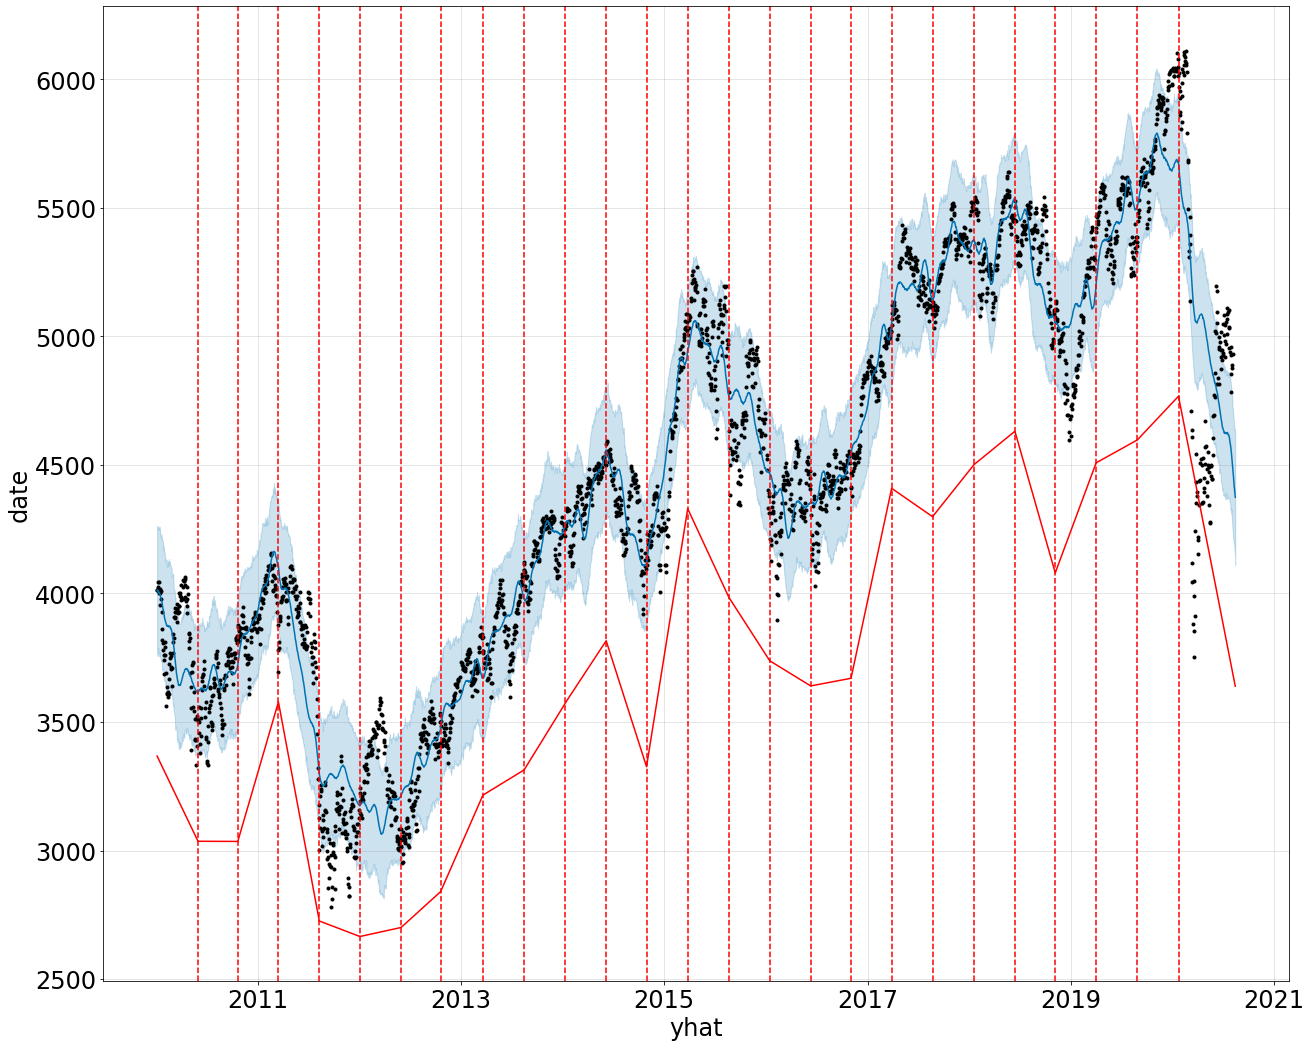

In [298]:
from matplotlib import pyplot as plt 

fig = df_prophet.plot(df_forecast_w_history)
fig.set_size_inches(20, 16)
plt.xlabel('yhat', fontsize=24)
plt.ylabel('date', fontsize=24)
plt.rcParams['xtick.labelsize']=8
plt.rcParams['ytick.labelsize']=8
a = add_changepoints_to_plot(fig.gca(), df_prophet, df_forecast_w_history)

In [299]:
fig.savefig('FBProphet_Forecast.png', bbox_inches='tight')

In [265]:
df_forecast_w_history.isna().sum()

ds                            0
trend                         0
yhat_lower                    0
yhat_upper                    0
trend_lower                   0
trend_upper                   0
multiplicative_terms          0
multiplicative_terms_lower    0
multiplicative_terms_upper    0
weekly                        0
weekly_lower                  0
weekly_upper                  0
yearly                        0
yearly_lower                  0
yearly_upper                  0
additive_terms                0
additive_terms_lower          0
additive_terms_upper          0
yhat                          0
dtype: int64

In [256]:
df_forecast_w_history.index = pd.to_datetime(df_forecast_w_history.ds)
df_forecast_w_history

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,
2010-01-04 09:00:00,2010-01-04 09:00:00,3367.732865,3758.026969,4256.070487,3367.732865,3367.732865,0.191222,0.191222,0.191222,0.196385,0.196385,0.196385,-0.005163,-0.005163,-0.005163,0.0,0.0,0.0,4011.718731
2010-01-05 09:00:00,2010-01-05 09:00:00,3365.478571,3778.635084,4265.986766,3365.478571,3365.478571,0.192718,0.192718,0.192718,0.197530,0.197530,0.197530,-0.004811,-0.004811,-0.004811,0.0,0.0,0.0,4014.067283
2010-01-06 09:00:00,2010-01-06 09:00:00,3363.224277,3763.716759,4259.129104,3363.224277,3363.224277,0.192970,0.192970,0.192970,0.197398,0.197398,0.197398,-0.004428,-0.004428,-0.004428,0.0,0.0,0.0,4012.226765
2010-01-07 09:00:00,2010-01-07 09:00:00,3360.969983,3780.547067,4248.124433,3360.969983,3360.969983,0.193291,0.193291,0.193291,0.197321,0.197321,0.197321,-0.004029,-0.004029,-0.004029,0.0,0.0,0.0,4010.616702
2010-01-08 09:00:00,2010-01-08 09:00:00,3358.715689,3794.064734,4258.639483,3358.715689,3358.715689,0.194074,0.194074,0.194074,0.197709,0.197709,0.197709,-0.003634,-0.003634,-0.003634,0.0,0.0,0.0,4010.556601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-10 09:00:00,2020-08-10 09:00:00,3661.505060,4177.104742,4662.580507,3661.505060,3661.505060,0.206756,0.206756,0.206756,0.196385,0.196385,0.196385,0.010371,0.010371,0.010371,0.0,0.0,0.0,4418.542245
2020-08-11 09:00:00,2020-08-11 09:00:00,3655.976474,4155.092844,4655.086558,3655.976474,3655.976474,0.206235,0.206235,0.206235,0.197530,0.197530,0.197530,0.008706,0.008706,0.008706,0.0,0.0,0.0,4409.967682
2020-08-12 09:00:00,2020-08-12 09:00:00,3650.447888,4155.465197,4646.083195,3650.447888,3650.447888,0.204511,0.204511,0.204511,0.197398,0.197398,0.197398,0.007113,0.007113,0.007113,0.0,0.0,0.0,4397.005374


In [261]:
df_price.loc[df_forecast_w_history.ds].y, df_forecast_w_history.yhat

(Datetime
 2010-01-04 09:00:00    4013.969971
 2010-01-05 09:00:00    4012.909912
 2010-01-06 09:00:00    4017.669922
 2010-01-07 09:00:00    4024.800049
 2010-01-08 09:00:00    4045.139893
                           ...     
 2020-08-10 09:00:00    4909.509766
 2020-08-11 09:00:00    5027.990234
 2020-08-12 09:00:00    5073.310059
 2020-08-13 09:00:00    5042.379883
 2020-08-14 09:00:00    4962.930176
 Name: y, Length: 2715, dtype: float64,
 ds
 2010-01-04 09:00:00    4011.718731
 2010-01-05 09:00:00    4014.067283
 2010-01-06 09:00:00    4012.226765
 2010-01-07 09:00:00    4010.616702
 2010-01-08 09:00:00    4010.556601
                           ...     
 2020-08-10 09:00:00    4418.542245
 2020-08-11 09:00:00    4409.967682
 2020-08-12 09:00:00    4397.005374
 2020-08-13 09:00:00    4384.591544
 2020-08-14 09:00:00    4374.282545
 Name: yhat, Length: 2715, dtype: float64)

In [262]:
mae = mean_absolute_error(df_price.loc[df_forecast_w_history.ds].y, df_forecast_w_history.yhat)
#df_forecast_w_history.yhat = df_forecast_w_history.yhat + mae

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Forecasting without History

In [301]:
fcast_time=9
df_forecast_wo_history = df_prophet.make_future_dataframe(periods= fcast_time, freq='D', include_history=False)
df_forecast_wo_history = df_forecast_wo_history[df_forecast_wo_history['ds'].dt.dayofweek < 5]
df_forecast_wo_history

,ds
0,2020-08-06 09:00:00
1,2020-08-07 09:00:00
4,2020-08-10 09:00:00
5,2020-08-11 09:00:00
6,2020-08-12 09:00:00
7,2020-08-13 09:00:00
8,2020-08-14 09:00:00


In [302]:
df_forecast_wo_history = df_prophet.predict(df_forecast_wo_history)
df_forecast_wo_history = df_forecast_wo_history[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df_forecast_wo_history.index = pd.to_datetime(df_forecast_wo_history.ds)
df_forecast_wo_history

,ds,yhat,yhat_lower,yhat_upper
ds,,,,
2020-08-06 09:00:00,2020-08-06 09:00:00,4474.285882,4231.482725,4727.392658
2020-08-07 09:00:00,2020-08-07 09:00:00,4462.610615,4232.299536,4709.301551
2020-08-10 09:00:00,2020-08-10 09:00:00,4418.542245,4156.125675,4665.418188
2020-08-11 09:00:00,2020-08-11 09:00:00,4409.967682,4171.867762,4637.144304
2020-08-12 09:00:00,2020-08-12 09:00:00,4397.005374,4163.747638,4645.419784
2020-08-13 09:00:00,2020-08-13 09:00:00,4384.591544,4134.168625,4624.774795
2020-08-14 09:00:00,2020-08-14 09:00:00,4374.282545,4127.419667,4611.690808


In [303]:
mae = mean_absolute_error(df_price.loc[df_forecast_wo_history.ds].y, df_forecast_wo_history.yhat)
df_forecast_wo_history.yhat = df_forecast_wo_history.yhat + mae

In [304]:
df_price.loc[df_forecast_wo_history.ds].y, df_forecast_wo_history.yhat

(Datetime
 2020-08-06 09:00:00    4885.129883
 2020-08-07 09:00:00    4889.520020
 2020-08-10 09:00:00    4909.509766
 2020-08-11 09:00:00    5027.990234
 2020-08-12 09:00:00    5073.310059
 2020-08-13 09:00:00    5042.379883
 2020-08-14 09:00:00    4962.930176
 Name: y, dtype: float64,
 ds
 2020-08-06 09:00:00    5027.069329
 2020-08-07 09:00:00    5015.394062
 2020-08-10 09:00:00    4971.325692
 2020-08-11 09:00:00    4962.751129
 2020-08-12 09:00:00    4949.788822
 2020-08-13 09:00:00    4937.374992
 2020-08-14 09:00:00    4927.065993
 Name: yhat, dtype: float64)

In [305]:
mean_squared_error(df_price.loc[df_forecast_wo_history.ds].y, df_forecast_wo_history.yhat)

10234.027641531455

In [306]:
2*np.std(df_price.loc[df_forecast_wo_history.ds])

y            144.743346
predictor      0.699854
dtype: float64

In [318]:
df_price['daily_returns'] = df_price.y.pct_change()*100
df_price['daily_returns_1'] = df_price['daily_returns'].shift(-1)
df_price['predictor'] = np.where( df_price.daily_returns_1 >= pred_threshold, 1, 0) 
df_price = df_price.drop(['daily_returns_1', 'daily_returns'], axis=1)
df_price
df_price.loc[df_forecast.ds]

,ds,y,predictor
Datetime,,,
2020-08-06 09:00:00,2020-08-06 09:00:00,4885.129883,0
2020-08-07 09:00:00,2020-08-07 09:00:00,4889.520020,0
2020-08-10 09:00:00,2020-08-10 09:00:00,4909.509766,1
2020-08-11 09:00:00,2020-08-11 09:00:00,5027.990234,0
2020-08-12 09:00:00,2020-08-12 09:00:00,5073.310059,0
2020-08-13 09:00:00,2020-08-13 09:00:00,5042.379883,0
2020-08-14 09:00:00,2020-08-14 09:00:00,4962.930176,0


In [320]:
df_forecast_wo_history['daily_returns'] = df_forecast_wo_history.yhat.pct_change()*100
df_forecast_wo_history['daily_returns_1'] = df_forecast_wo_history['daily_returns'].shift(-1)
df_forecast_wo_history.ds = pd.to_datetime(df_forecast_wo_history.ds)
df_forecast_wo_history.index = pd.to_datetime(df_forecast_wo_history.ds)


df_forecast_wo_history['predictor'] = np.where( df_forecast_wo_history.daily_returns_1 >= pred_threshold, 1, 0) 
df_forecast_wo_history = df_forecast_wo_history.drop(['daily_returns_1', 'daily_returns'], axis=1)

(df_forecast_wo_history, df_price.loc[df_forecast_wo_history.index])

(                                     ds         yhat   yhat_lower  \
 ds                                                                  
 2020-08-06 09:00:00 2020-08-06 09:00:00  5027.069329  4231.482725   
 2020-08-07 09:00:00 2020-08-07 09:00:00  5015.394062  4232.299536   
 2020-08-10 09:00:00 2020-08-10 09:00:00  4971.325692  4156.125675   
 2020-08-11 09:00:00 2020-08-11 09:00:00  4962.751129  4171.867762   
 2020-08-12 09:00:00 2020-08-12 09:00:00  4949.788822  4163.747638   
 2020-08-13 09:00:00 2020-08-13 09:00:00  4937.374992  4134.168625   
 2020-08-14 09:00:00 2020-08-14 09:00:00  4927.065993  4127.419667   
 
                       yhat_upper  predictor  
 ds                                           
 2020-08-06 09:00:00  4727.392658          0  
 2020-08-07 09:00:00  4709.301551          0  
 2020-08-10 09:00:00  4665.418188          0  
 2020-08-11 09:00:00  4637.144304          0  
 2020-08-12 09:00:00  4645.419784          0  
 2020-08-13 09:00:00  4624.774795      

In [321]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [333]:
f1_score(df_forecast_wo_history.predictor, df_price.loc[df_forecast_wo_history.index].predictor)


0.0

In [331]:
np.round(precision_score(df_forecast_wo_history.predictor, df_price.loc[df_forecast_wo_history.index].predictor), 2)*100

0.0

In [332]:
np.round(recall_score(df_forecast_wo_history.predictor, df_price.loc[df_forecast_wo_history.index].predictor), 2)*100

0.0

In [330]:
print(confusion_matrix(df_forecast_wo_history.predictor, df_price.loc[df_forecast_wo_history.index].predictor ))

[[6 1]
 [0 0]]


In [316]:
df_forecast_wo_history

,ds,yhat,yhat_lower,yhat_upper,predictor
ds,,,,,
2020-08-06 09:00:00,2020-08-06 09:00:00,5027.069329,4231.482725,4727.392658,0
2020-08-07 09:00:00,2020-08-07 09:00:00,5015.394062,4232.299536,4709.301551,0
2020-08-10 09:00:00,2020-08-10 09:00:00,4971.325692,4156.125675,4665.418188,0
2020-08-11 09:00:00,2020-08-11 09:00:00,4962.751129,4171.867762,4637.144304,0
2020-08-12 09:00:00,2020-08-12 09:00:00,4949.788822,4163.747638,4645.419784,0
2020-08-13 09:00:00,2020-08-13 09:00:00,4937.374992,4134.168625,4624.774795,0
2020-08-14 09:00:00,2020-08-14 09:00:00,4927.065993,4127.419667,4611.690808,0


### Save the Model

In [68]:
with open("Models/FCHI_FBPROPHET_PT_1_BUY.pkl", "wb") as f:
     joblib.dump(df_prophet, f)

In [69]:
mdl_pickle = joblib.load('Models/FCHI_FBPROPHET_PT_1_BUY.pkl')